In [22]:
!git clone https://github.com/atikul-islam-sajib/TreeBasedModel.git

In [2]:
%cd TreeBasedModel

/content/TreeBasedModel


In [22]:
!pip install shap

In [22]:
!pip install -e .

### Task ?

specified that I do not intend to optimize the parameter \( k \) this time, but rather to document the results for each value of \( k \). Specifically, goal is to visualize importance measures—MDI and SHAP included—as functions of \( k \), while keeping the `max_features` parameter at its default setting. There is no need to optimize for ROC AUC scores; however, want these scores recorded for each \( k \). Furthermore, for each level of feature relevance, aim to produce a set of four plots that illustrate these metrics.

In [16]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from TreeModelsFromScratch.RandomForest import RandomForest
from utils import simulate_data_strobl
from matplotlib import pyplot as plt

#### With K and Max Feature = Default - Custom RF

In [18]:
def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score."""
    return roc_auc_score(y_true, y_scores)

def evaluate_models(X_train, y_train, X_test, y_test, k_values, iterations=20, depth_dof=False):
    """Evaluate RandomForest models for a range of k values and record MDI, SHAP, and ROC AUC over specified iterations."""
    results = []
    for k in k_values:
        roc_aucs, mdi_importances, shap_values_all = [], [], []
        for _ in range(iterations):
            model = RandomForest(treetype="classification", n_trees=25, k=k, random_state=42, oob_SHAP=True, depth_dof=depth_dof)
            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            roc_aucs.append(calculate_auc_roc(y_test, y_scores))
            mdi_importances.append(model.feature_importances_)
            shap_values_all.append(np.mean(np.abs(model.oob_SHAP_values), axis=0))

        results.append({
            'k': k,
            'roc_auc': np.mean(roc_aucs),
            'mdi_importances': np.mean(mdi_importances, axis=0),
            'shap_values': np.mean(shap_values_all, axis=0)
        })
    return results

In [19]:
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = range(1, 31)
all_results = []

for relevance in relevance_values:
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = evaluate_models(X_train, y_train, X_test, y_test, k_values, iterations=20, depth_dof=False) # Iteration 20, depth = False
    all_results.append({'relevance': relevance, 'results': results})

# Save results to a pickle file
with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(all_results, file)

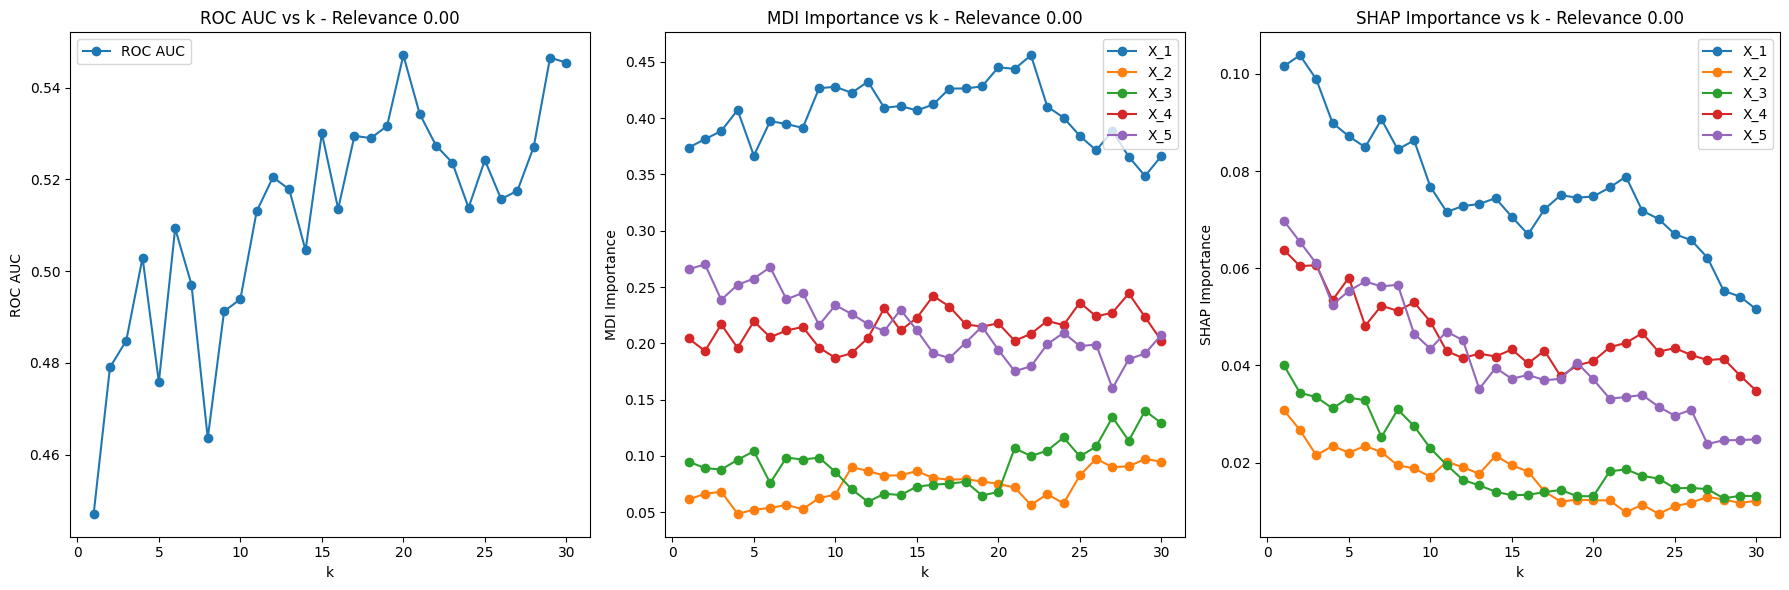

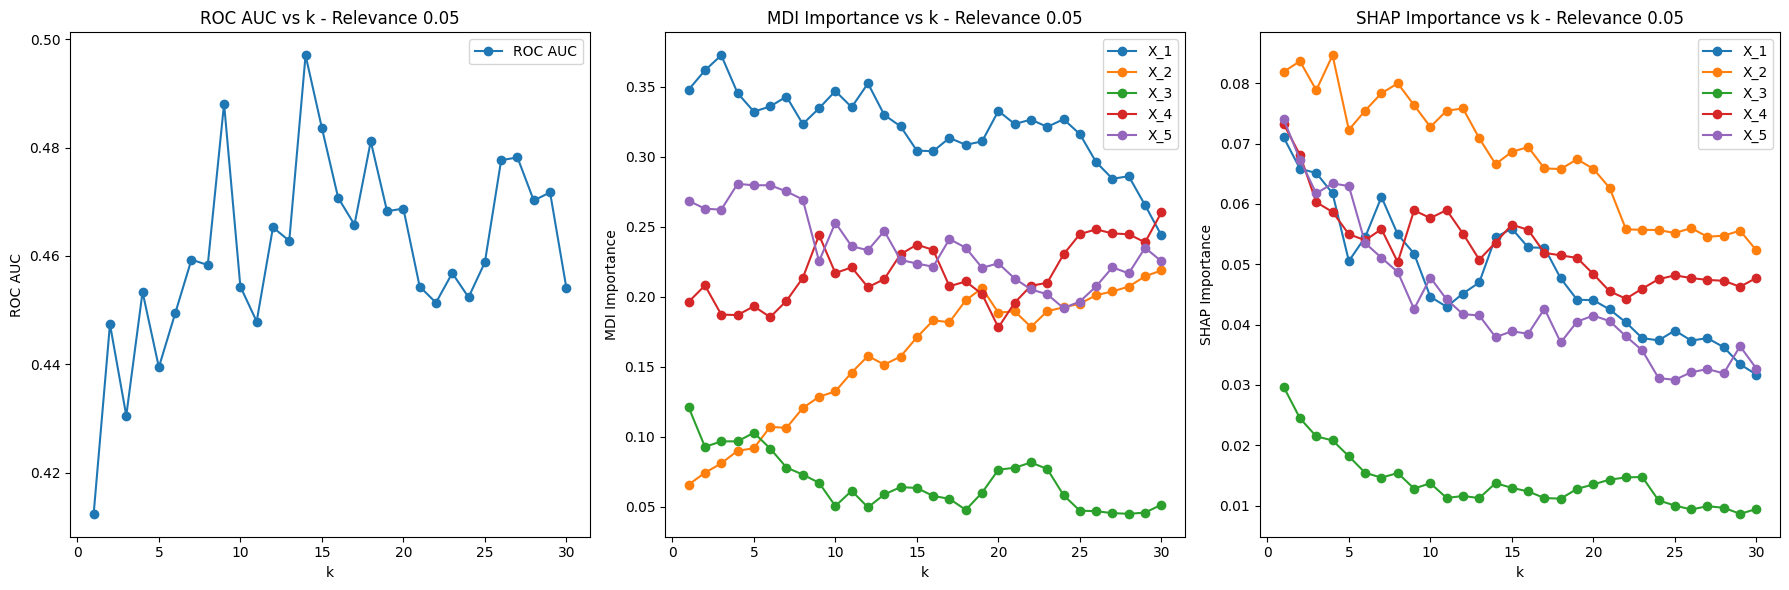

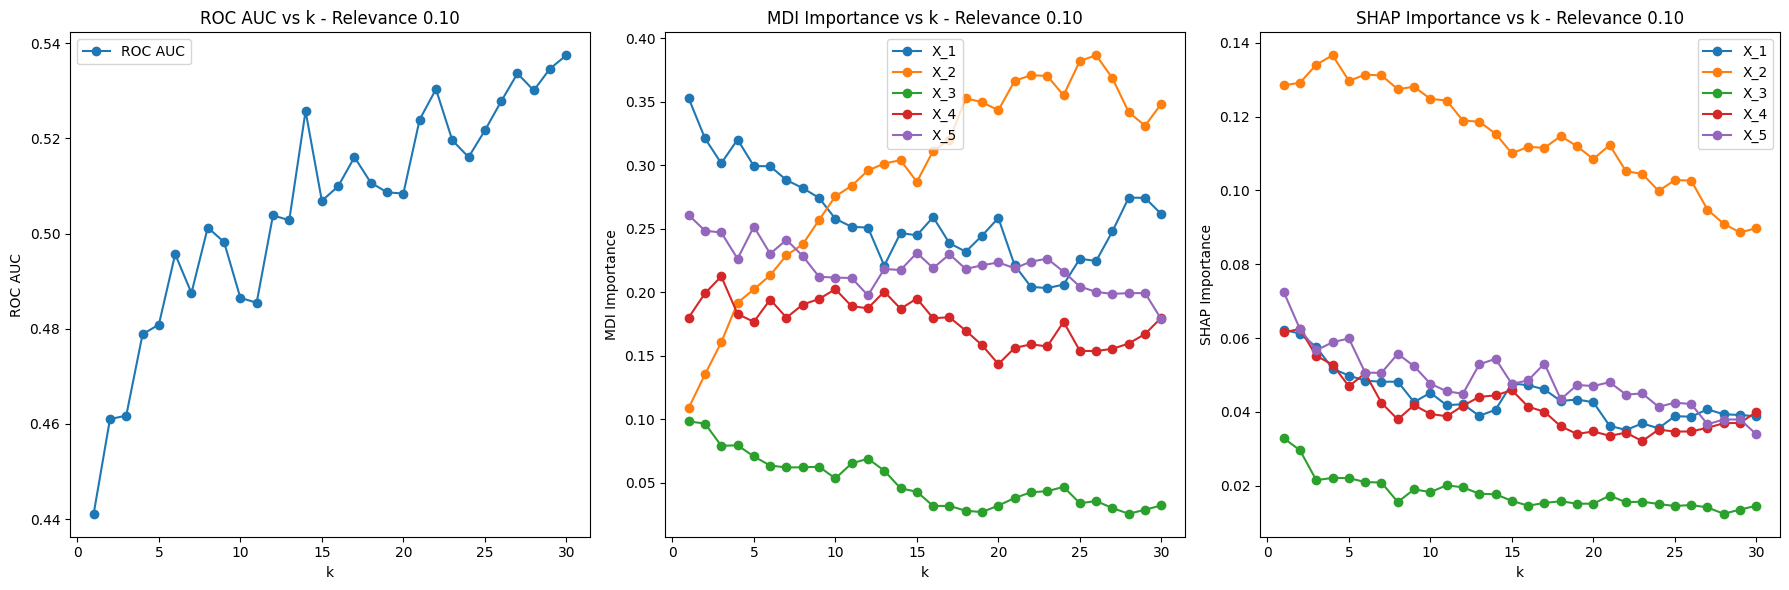

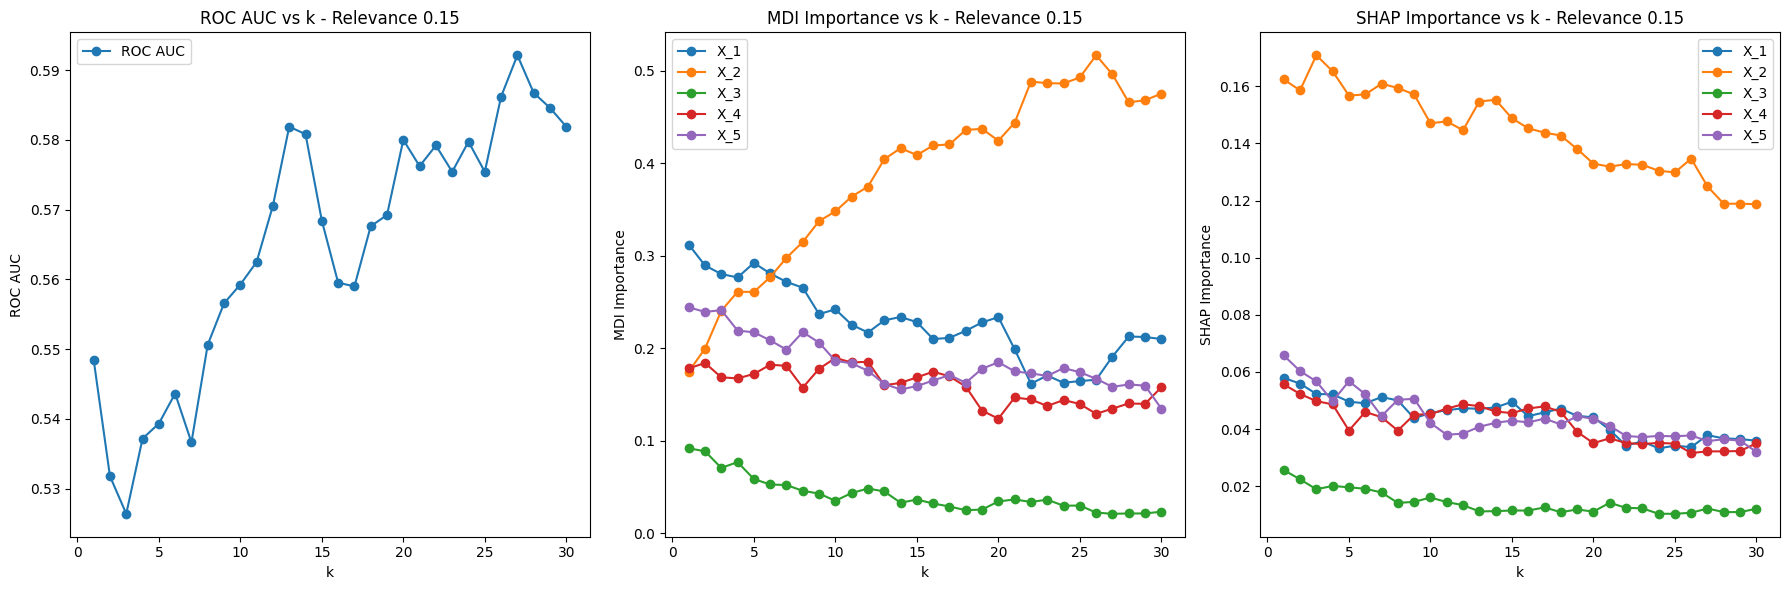

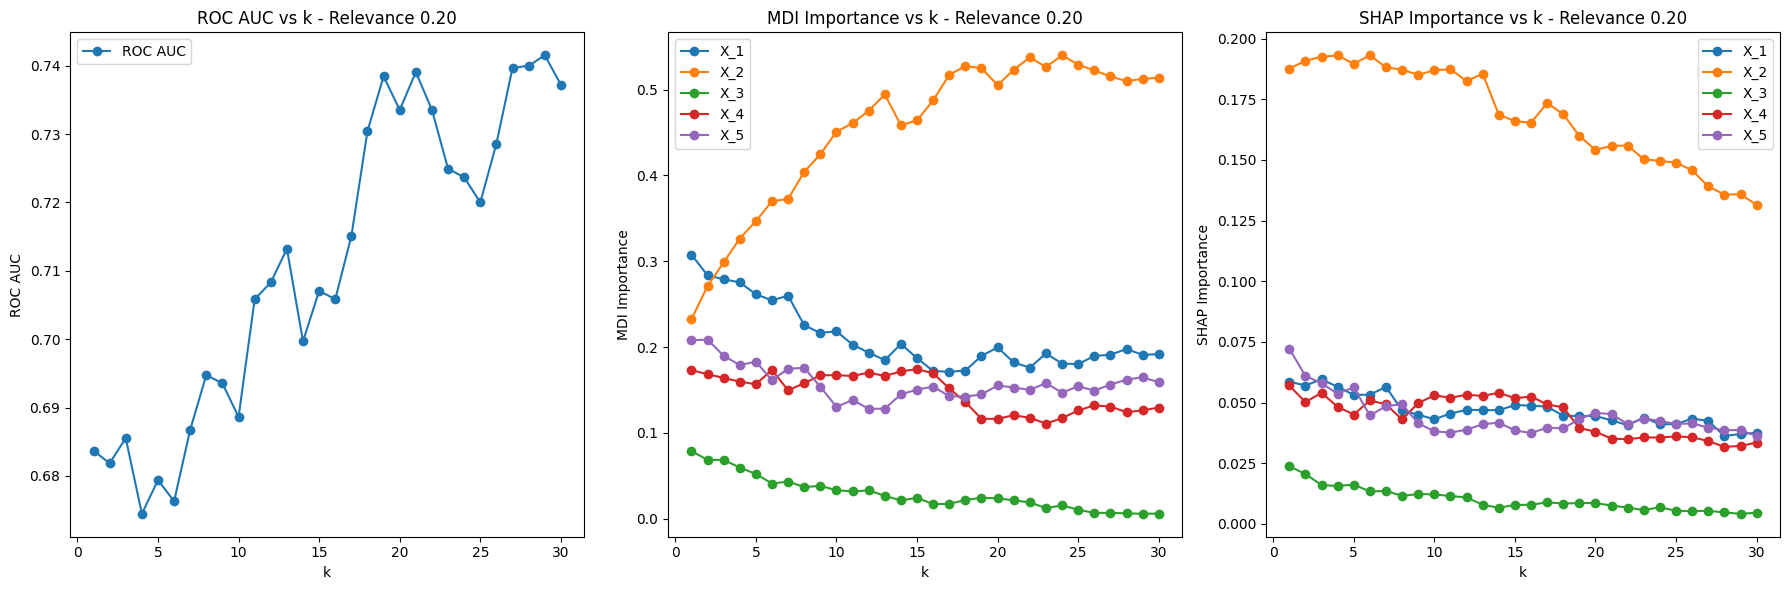

In [20]:
# Plotting results with revised legends and titles
for relevance_result in all_results:
    relevance = relevance_result['relevance']
    plt.figure(figsize=(18, 6))

    ks = [result['k'] for result in relevance_result['results']]
    rocs = [result['roc_auc'] for result in relevance_result['results']]
    mdi_importances = [result['mdi_importances'] for result in relevance_result['results']]
    shap_importances = [result['shap_values'] for result in relevance_result['results']]

    plt.subplot(1, 3, 1)
    plt.plot(ks, rocs, label=f'ROC AUC', marker="o")
    plt.title(f'ROC AUC vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('ROC AUC')
    plt.legend()

    plt.subplot(1, 3, 2)
    for feature_idx in range(mdi_importances[0].shape[0]):
        mdi_feature_means = [mdi[feature_idx] for mdi in mdi_importances]
        plt.plot(ks, mdi_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'MDI Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('MDI Importance')
    plt.legend()

    plt.subplot(1, 3, 3)
    for feature_idx in range(shap_importances[0].shape[0]):
        shap_feature_means = [shap[feature_idx] for shap in shap_importances]
        plt.plot(ks, shap_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'SHAP Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('SHAP Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()

### With Depth and K - > depth = True

In [21]:
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = range(1, 31)
all_results = []

for relevance in relevance_values:
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = evaluate_models(X_train, y_train, X_test, y_test, k_values, depth_dof=True, iterations=20) # Iteration 20, depth_dof = True
    all_results.append({'relevance': relevance, 'results': results})

# Save results to a pickle file
with open('evaluation_results_depth_true.pkl', 'wb') as file:
    pickle.dump(all_results, file)

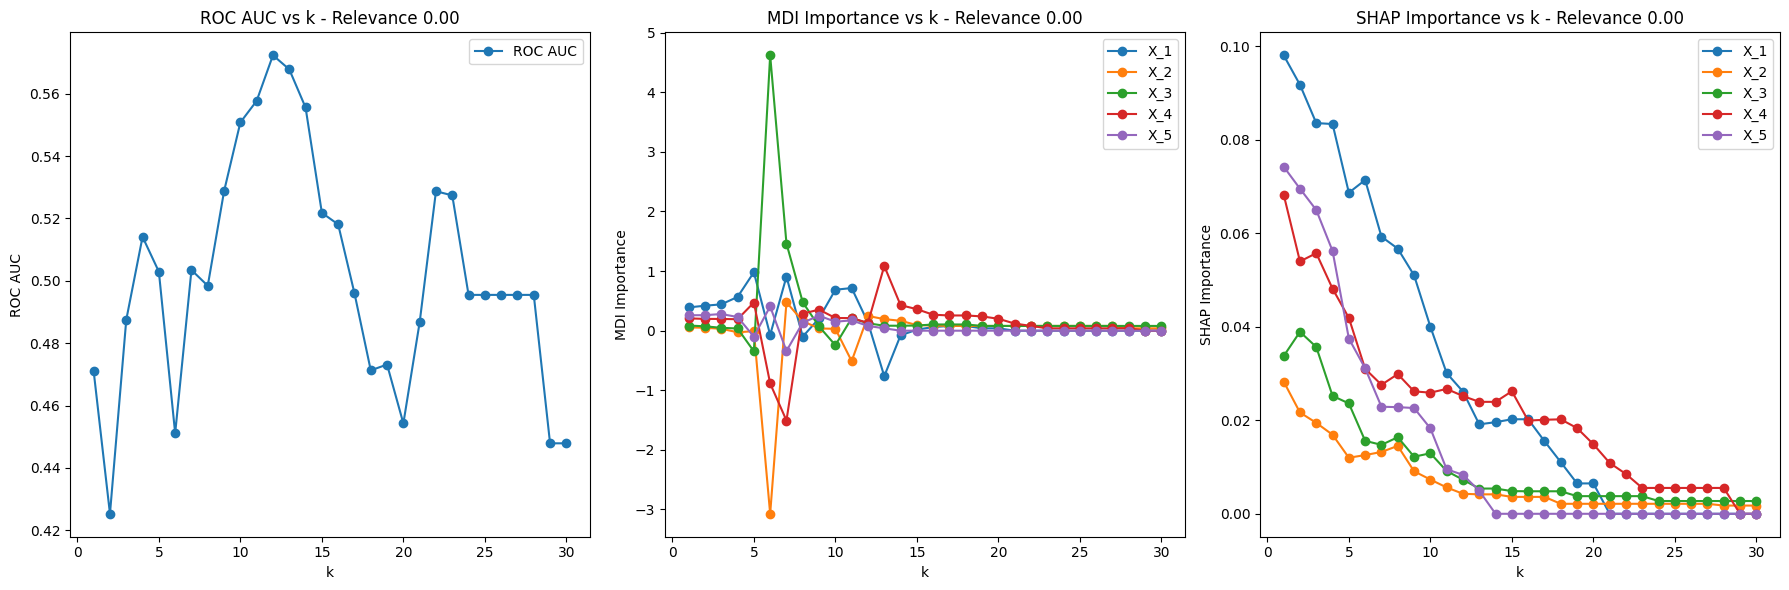

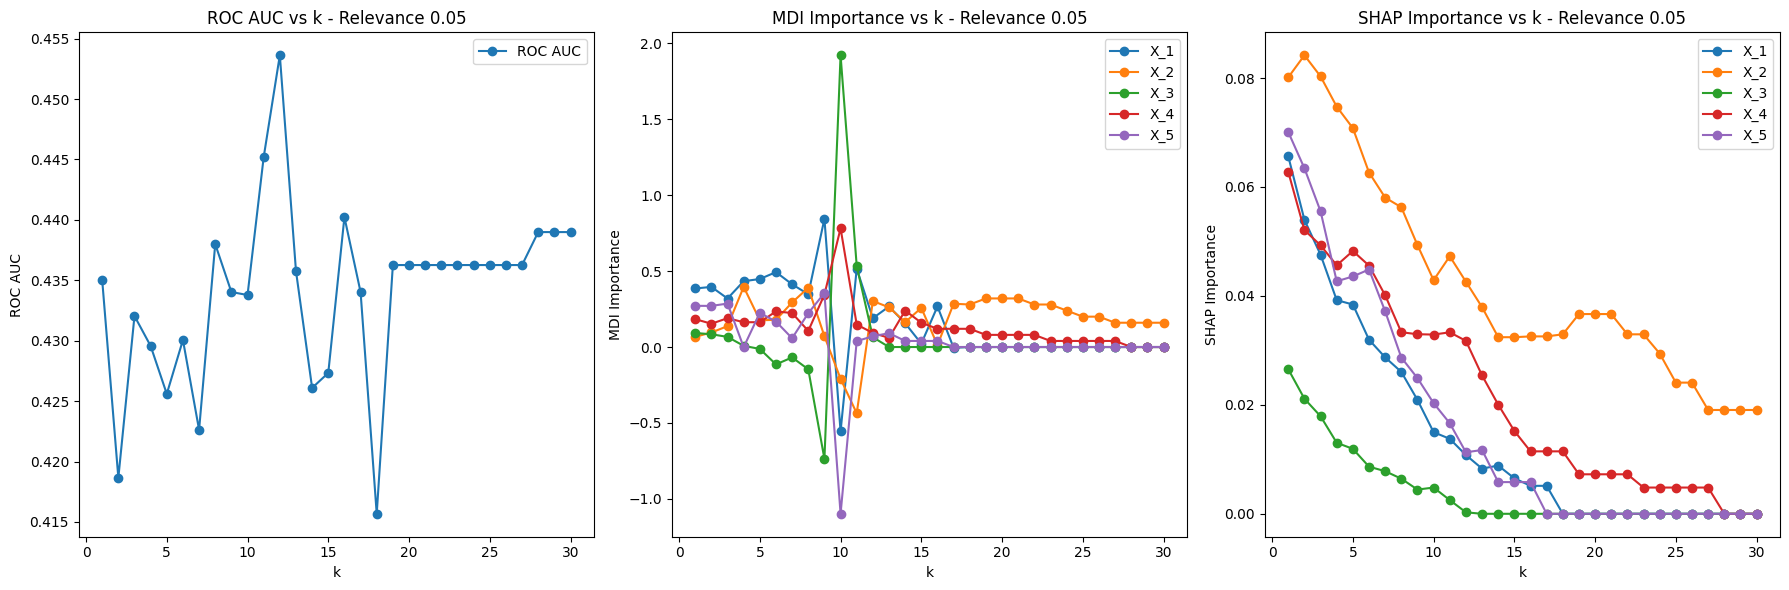

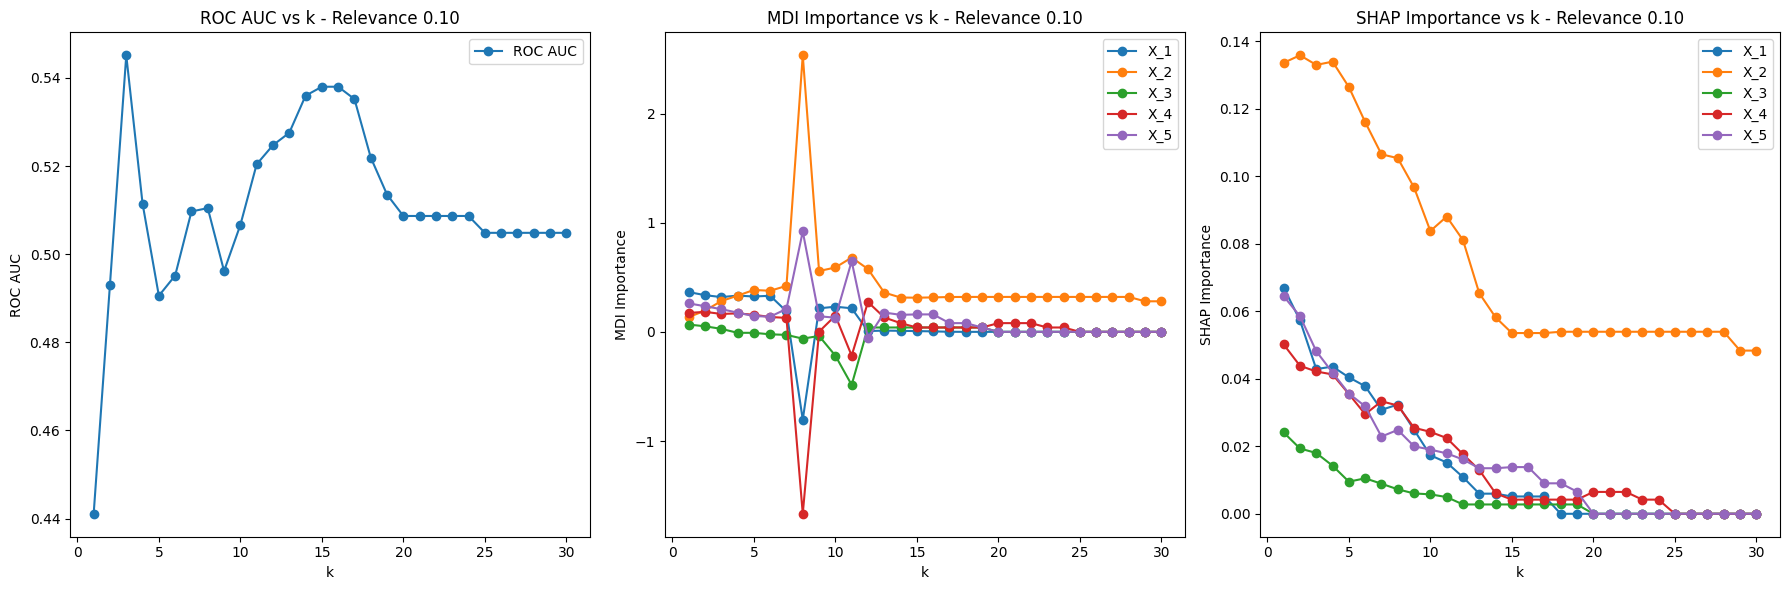

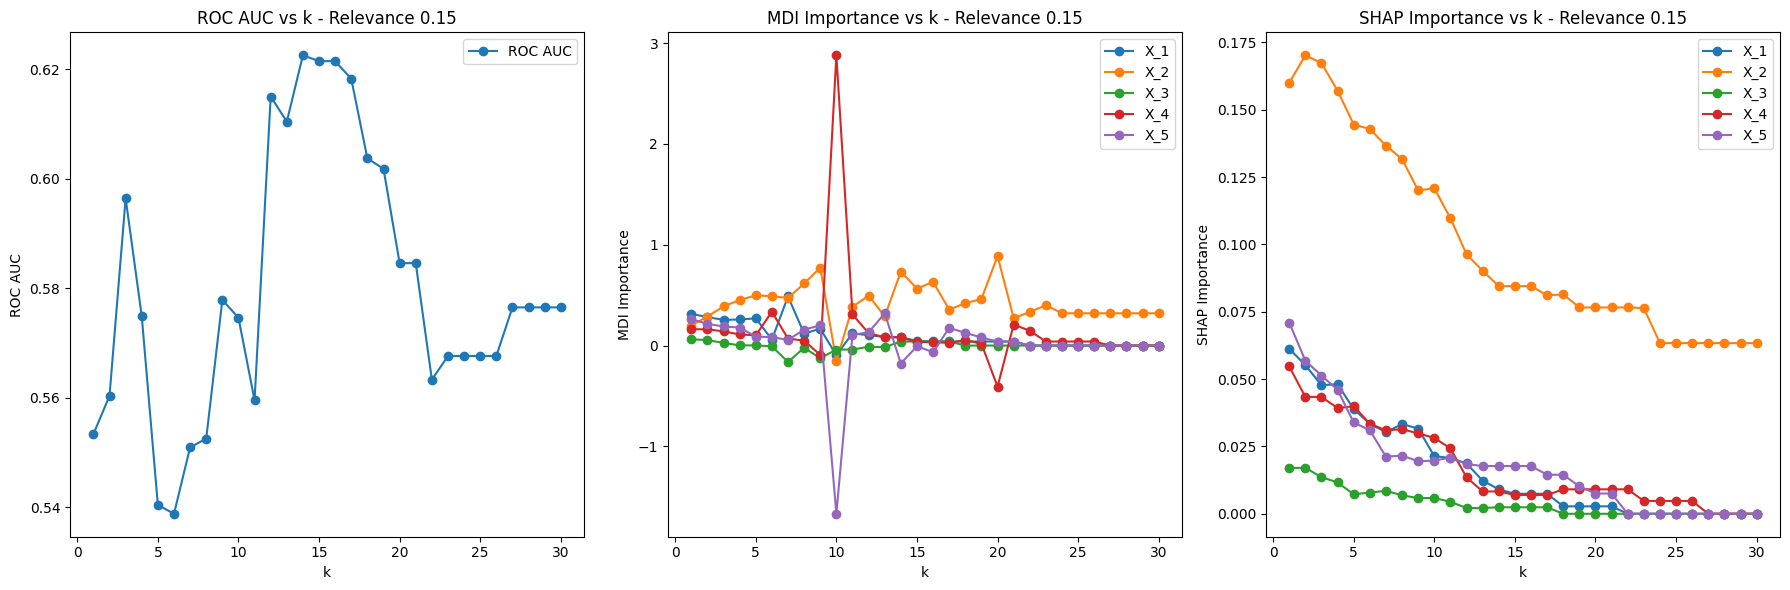

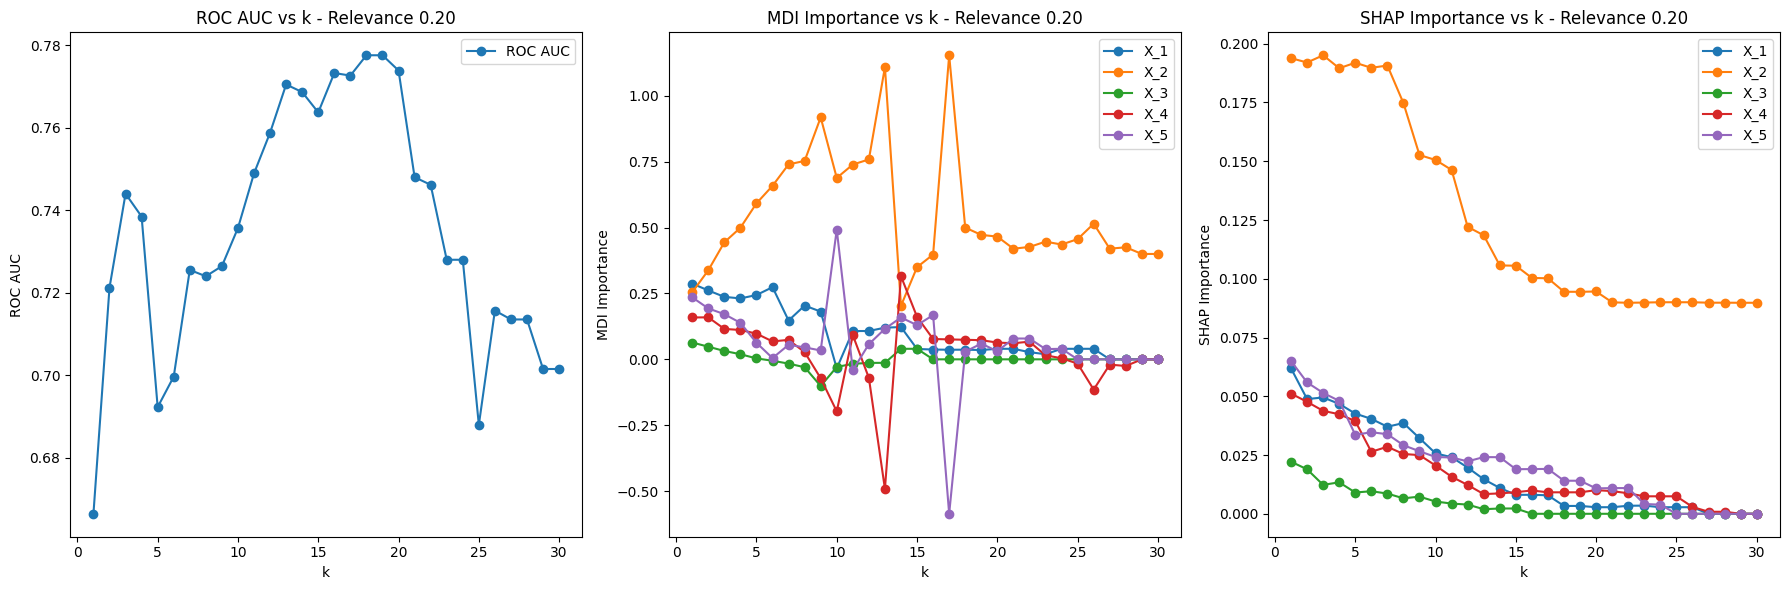

In [22]:
# Plotting results with revised legends and titles
for relevance_result in all_results:
    relevance = relevance_result['relevance']
    plt.figure(figsize=(18, 6))

    ks = [result['k'] for result in relevance_result['results']]
    rocs = [result['roc_auc'] for result in relevance_result['results']]
    mdi_importances = [result['mdi_importances'] for result in relevance_result['results']]
    shap_importances = [result['shap_values'] for result in relevance_result['results']]

    plt.subplot(1, 3, 1)
    plt.plot(ks, rocs, label=f'ROC AUC', marker="o")
    plt.title(f'ROC AUC vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('ROC AUC')
    plt.legend()

    plt.subplot(1, 3, 2)
    for feature_idx in range(mdi_importances[0].shape[0]):
        mdi_feature_means = [mdi[feature_idx] for mdi in mdi_importances]
        plt.plot(ks, mdi_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'MDI Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('MDI Importance')
    plt.legend()

    plt.subplot(1, 3, 3)
    for feature_idx in range(shap_importances[0].shape[0]):
        shap_feature_means = [shap[feature_idx] for shap in shap_importances]
        plt.plot(ks, shap_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'SHAP Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('SHAP Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()